Copyright (c) András Kalapos. All rights reserved.

This source code is licensed under the license found in the
LICENSE file in the root directory of this source tree.

Attribution Information:

Parts of this script is based on the implementation by Meta Platforms, Inc. and affiliates.

The original implementation can be found at 
https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py

The original implementation is licensed under the CC BY-NC 4.0 license found at 
https://github.com/facebookresearch/ijepa/blob/main/LICENSE

In [1]:

import math

from multiprocessing import Value

import torch

class MultiBlockMask(object):

    def __init__(
        self,
        input_size=(224, 224),
        patch_size=32,
        enc_mask_scale=(0.85, 1.0),
        pred_mask_scale=(0.15, 0.2),
        aspect_ratio=(0.75, 1.5),
        num_enc_blocks=1,
        num_pred_blocks=4,
        min_keep=4,
        allow_overlap=False
    ):
        super(MultiBlockMask, self).__init__()
        if not isinstance(input_size, tuple):
            input_size = (input_size, ) * 2
        self.patch_size = patch_size
        self.height, self.width = input_size[0] // patch_size, input_size[1] // patch_size
        self.enc_mask_scale = enc_mask_scale
        self.pred_mask_scale = pred_mask_scale
        self.aspect_ratio = aspect_ratio
        self.nenc = num_enc_blocks
        self.npred = num_pred_blocks
        self.min_keep = min_keep  # minimum number of patches to keep
        self.allow_overlap = allow_overlap  # whether to allow overlap b/w enc and pred masks        
        self._itr_counter = Value('i', -1)  # collator is shared across worker processes

    def step(self):
        i = self._itr_counter
        with i.get_lock():
            i.value += 1
            v = i.value
        return v


    def _sample_block_size(self, generator, scale, aspect_ratio_scale):
        _rand = torch.rand(1, generator=generator).item()
        # -- Sample block scale
        min_s, max_s = scale
        mask_scale = min_s + _rand * (max_s - min_s)
        max_keep = int(self.height * self.width * mask_scale)
        # -- Sample block aspect-ratio
        min_ar, max_ar = aspect_ratio_scale
        aspect_ratio = min_ar + _rand * (max_ar - min_ar)
        # -- Compute block height and width (given scale and aspect-ratio)
        h = int(round(math.sqrt(max_keep * aspect_ratio)))
        w = int(round(math.sqrt(max_keep / aspect_ratio)))
        while h > self.height:
            h -= 1
        while w > self.width:
            w -= 1

        return (h, w)

    def _sample_block_mask(self, b_size, acceptable_regions=None):
        h, w = b_size

        def constrain_mask(mask, tries=0):
            """ Helper to restrict given mask to a set of acceptable regions """
            N = max(int(len(acceptable_regions)-tries), 0)
            for k in range(N):
                mask *= acceptable_regions[k]
        # --
        # -- Loop to sample masks until we find a valid one
        tries = 0
        timeout = og_timeout = 20
        valid_mask = False
        while not valid_mask:
            if self.height - h > 0 and self.width - w > 0:
                # -- Sample block top-left corner
                top = torch.randint(0, self.height - h, (1,))
                left = torch.randint(0, self.width - w, (1,))
            else:
                top = 0
                left = 0
                                
            mask = torch.zeros((self.height, self.width), dtype=torch.int32)
            mask[top:top+h, left:left+w] = 1

            # -- Constrain mask to a set of acceptable regions
            if acceptable_regions is not None:
                constrain_mask(mask, tries)
            mask = torch.nonzero(mask.flatten())
            # -- If mask too small try again
            valid_mask = len(mask) > self.min_keep
            if not valid_mask:
                timeout -= 1
                if timeout == 0:
                    tries += 1
                    timeout = og_timeout
        mask = mask.squeeze()
        # --
        mask_complement = torch.ones((self.height, self.width), dtype=torch.int32)
        mask_complement[top:top+h, left:left+w] = 0
        # --
        return mask, mask_complement

    def __call__(self, batch_size):
        '''
        Create encoder and predictor masks when collating imgs into a batch
        # 1. sample enc block (size + location) using seed
        # 2. sample pred block (size) using seed
        # 3. sample several enc block locations for each image (w/o seed)
        # 4. sample several pred block locations for each image (w/o seed)
        # 5. return enc mask and pred mask
        '''
        
        seed = self.step()
        g = torch.Generator()
        g.manual_seed(seed)
        p_size = self._sample_block_size(
            generator=g,
            scale=self.pred_mask_scale,
            aspect_ratio_scale=self.aspect_ratio)
        e_size = self._sample_block_size(
            generator=g,
            scale=self.enc_mask_scale,
            aspect_ratio_scale=(1., 1.))
        print(e_size)

        collated_masks_pred, collated_masks_enc = [], []
        min_keep_pred = self.height * self.width
        min_keep_enc = self.height * self.width
        for _ in range(batch_size):

            masks_p, masks_C = [], []
            for _ in range(self.npred):
                mask, mask_C = self._sample_block_mask(p_size)
                masks_p.append(mask)
                masks_C.append(mask_C)
                min_keep_pred = min(min_keep_pred, len(mask))
            collated_masks_pred.append(masks_p)

            acceptable_regions = masks_C
            try:
                if self.allow_overlap:
                    acceptable_regions= None
            except Exception as e:
                print(f'Encountered exception in mask-generator {e}')

            masks_e = []
            for _ in range(self.nenc):
                mask, _ = self._sample_block_mask(e_size, acceptable_regions=acceptable_regions)
                masks_e.append(mask)
                min_keep_enc = min(min_keep_enc, len(mask))
            collated_masks_enc.append(masks_e)

        # This is only needed for ViTs
        # collated_masks_pred = [[cm[:min_keep_pred] for cm in cm_list] for cm_list in collated_masks_pred]
        # collated_masks_enc = [[cm[:min_keep_enc] for cm in cm_list] for cm_list in collated_masks_enc]

        # merge blocks to mask
        collated_masks_pred = [torch.cat(cm_list).unique() for cm_list in collated_masks_pred]
        collated_masks_enc = [torch.cat(cm_list).unique() for cm_list in collated_masks_enc]

        print(collated_masks_enc)
        # Convert to width x height binary mask from index
        collated_masks_pred = [self.indeces_to_hw_mask(m) for m in collated_masks_pred]
        collated_masks_enc = [self.indeces_to_hw_mask(m) for m in collated_masks_enc]

        # Stack masks
        collated_masks_enc = torch.stack(collated_masks_enc)
        collated_masks_pred = torch.stack(collated_masks_pred)

        return collated_masks_enc, collated_masks_pred
    
    def indeces_to_hw_mask(self, indeces):
        mask = torch.zeros((self.height*self.width), dtype=torch.int32)
        mask[indeces] = 1
        mask = mask.view(self.height, self.width)
        return mask

In [2]:
a = [1,2,2,4,5,6,6,7]
len(a)
a[:len(a)]

[1, 2, 2, 4, 5, 6, 6, 7]

In [3]:
m = MultiBlockMask(patch_size=32, num_pred_blocks=2, enc_mask_scale=(0.85, 1.0))

In [4]:
context_m, target_m = m(2)
print(len(context_m), len(target_m))
print(context_m.shape, target_m.shape)
print("context\n", context_m)
print("target\n", target_m)

(7, 7)
[tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 19, 20, 21,
        26, 27, 28, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
        48]), tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 13, 14, 15, 16, 20, 27, 31, 32,
        33, 34, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])]
2 2
torch.Size([2, 7, 7]) torch.Size([2, 7, 7])
context
 tensor([[[1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1],
         [1, 0, 0, 0, 0, 1, 1],
         [1, 0, 0, 0, 0, 1, 1],
         [1, 0, 0, 0, 0, 1, 1],
         [1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1]],

        [[1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 0, 0, 0, 1],
         [1, 1, 1, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1]]], dtype=torch.int32)
target
 tensor([[[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 1, 1, 1, 1, 0, 0],
         [0, 1, 1, 1, 1, 0, 0],
         [0,

In [5]:
m(2)


(7, 7)
[tensor([ 0,  1,  5,  6,  7,  8, 12, 13, 14, 15, 19, 20, 21, 22, 23, 27, 28, 29,
        30, 34, 35, 36, 37, 41, 42, 43, 44, 45, 46, 47, 48]), tensor([ 3,  4,  5,  6, 10, 11, 12, 13, 17, 18, 19, 20, 24, 25, 26, 27, 28, 29,
        30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
        48])]


(tensor([[[1, 1, 0, 0, 0, 1, 1],
          [1, 1, 0, 0, 0, 1, 1],
          [1, 1, 0, 0, 0, 1, 1],
          [1, 1, 1, 0, 0, 0, 1],
          [1, 1, 1, 0, 0, 0, 1],
          [1, 1, 1, 0, 0, 0, 1],
          [1, 1, 1, 1, 1, 1, 1]],
 
         [[0, 0, 0, 1, 1, 1, 1],
          [0, 0, 0, 1, 1, 1, 1],
          [0, 0, 0, 1, 1, 1, 1],
          [0, 0, 0, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1]]], dtype=torch.int32),
 tensor([[[0, 0, 1, 1, 1, 0, 0],
          [0, 0, 1, 1, 1, 0, 0],
          [0, 0, 1, 1, 1, 0, 0],
          [0, 0, 0, 1, 1, 1, 0],
          [0, 0, 0, 1, 1, 1, 0],
          [0, 0, 0, 1, 1, 1, 0],
          [0, 0, 0, 0, 0, 0, 0]],
 
         [[1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0]]], dtype=torch.int32))

In [6]:
g = torch.Generator()

In [7]:
m._sample_block_size(
            generator=g,
            scale=(0.8, 1.0),
            aspect_ratio_scale=(1., 1.))

(6, 6)

# Masking Visualization


In [8]:
from self_supervised_lightly.ijepa_mask import MultiBlockMask
import matplotlib.pyplot as plt
import torch

In [102]:
multi_block_kwargs = {
    'aspect_ratio': [0.75, 1.5],
    'enc_mask_scale': [1.0, 1.0],
    'min_keep': 5, # initially 10
    'num_enc_blocks': 1,
    'num_pred_blocks': 4,
    'pred_mask_scale': [0.15, 0.2],
}
multi_block_mask = MultiBlockMask(
    input_size=224,
    patch_size=32,
    **multi_block_kwargs
)

def get_multi_block_mask(B=1):
    context_mask, target_mask = multi_block_mask(B)
    context_mask = context_mask.unsqueeze(1).to(dtype=torch.bool)
    target_mask = target_mask.unsqueeze(1).to(dtype=torch.bool)
    return context_mask, target_mask


def get_random_mask(mask_ratio=0.6, fmap_h=7, fmap_w=7, B=1, generator=None):
    h, w = fmap_h, fmap_w
    len_keep = round(fmap_h * fmap_w * (1 - mask_ratio))
    idx = torch.rand(B, h * w, generator=generator).argsort(dim=1)
    idx = idx[:, :len_keep]  # (B, len_keep)
    context_mask = torch.zeros(B, h * w, dtype=torch.bool).scatter_(dim=1, index=idx, value=True).view(B, 1, h, w)
    target_mask = context_mask.logical_not()
    return context_mask, target_mask

def mask(B: int, strategy = "mixed", mixed_mutli_block_ratio=0.75):
        if strategy == "mixed":
            if torch.rand(1) < mixed_mutli_block_ratio:
                strategy = "multi-block"
            else:
                strategy = "random"
        else:
            strategy = strategy
        if strategy == "random":
            return get_random_mask(B=B)
        elif strategy == "multi-block":
            return get_multi_block_mask(B)

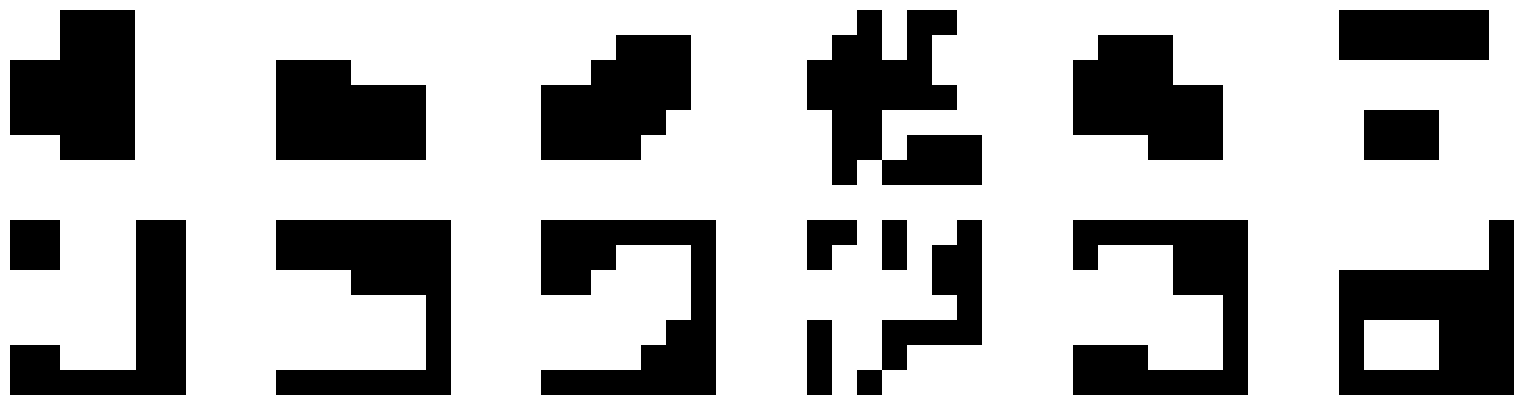

In [107]:
n = 6
masks = [mask(1) for _ in range(n)]

fig, axs = plt.subplots(2, n, figsize=(20, 5))
for i, (context_mask, target_mask) in enumerate(masks):
    axs[0, i].imshow(context_mask.squeeze().numpy(), cmap='gray')
    axs[1, i].imshow(target_mask.squeeze().numpy(), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].axis('off')


In [79]:
from data.hdf5_imagefolder import HDF5ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import os
import numpy as np

transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
    ]
)

ds = HDF5ImageFolder(root="/data/imagenet-100-train.h5")

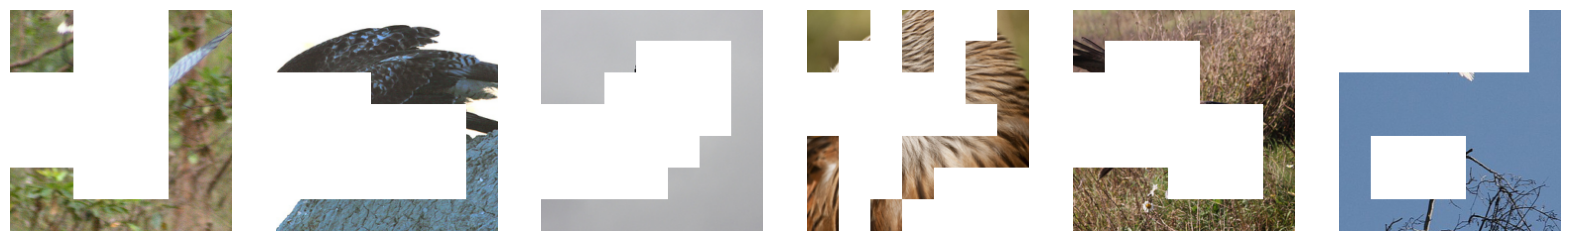

In [117]:
downsample_raito = 32

fig, axs = plt.subplots(1, n, figsize=(20, 6))
for i, (context_mask, target_mask) in enumerate(masks):
    im, _ = ds[i+20000]
    im = transform(im)
    im_mask = context_mask.repeat_interleave(downsample_raito, 2).repeat_interleave(downsample_raito, 3)  # (B, 1, H, W)
    t_mask = target_mask.repeat_interleave(downsample_raito, 2).repeat_interleave(downsample_raito, 3)  # (B, 1, H, W)
    im_mask = im_mask.squeeze().numpy()[..., None]
    t_mask = t_mask.squeeze().numpy()[..., None]
    masked_im = im*im_mask + 255*(t_mask)
    axs[i].imshow(masked_im)
    axs[i].axis('off')
    # save the images
    os.makedirs("example_masked_images", exist_ok=True)
    plt.imsave(f"example_masked_images/im_{i}.png", np.array(im).astype(np.uint8))
    plt.imsave(f"example_masked_images/masked_im_{i}_e.png", masked_im.astype(np.uint8))


In [116]:
!zip -r example_masked_images.zip example_masked_images

  adding: example_masked_images/ (stored 0%)
  adding: example_masked_images/masked_im_6_2.png (deflated 0%)
  adding: example_masked_images/masked_im_6_1.png (deflated 0%)
  adding: example_masked_images/im_6.png (deflated 0%)
  adding: example_masked_images/masked_im_6_5.png (deflated 0%)
  adding: example_masked_images/masked_im_6_3.png (deflated 0%)
  adding: example_masked_images/masked_im_6_4.png (deflated 0%)
  adding: example_masked_images/masked_im_6_0.png (deflated 0%)
